In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
from tests.leandro.tools import get_real_data, get_one_worm_data
from tests.leandro.plots import *
from minisom import MiniSom
import numpy as np

In [3]:
# Real data
dataset = get_real_data('/home/lrvnc/Projects/worm-graph/conf/dataset.yaml')


config:
	 dataset:
  name: Flavell2023


Chosen dataset(s): ['Flavell2023']
Num. worms: 50



In [4]:
oneWorm, calcium_data, time_vector = get_one_worm_data(dataset)

Worm ID: worm10


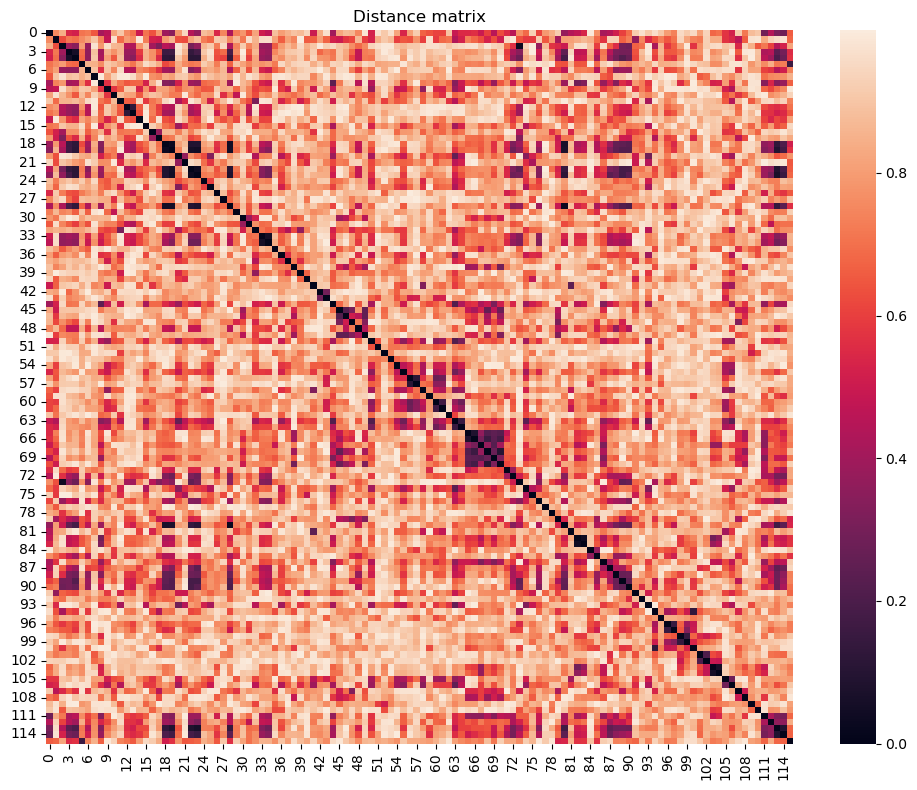

In [51]:
X = oneWorm['smooth_calcium_data'] # (time, all neurons)
X = X[:, oneWorm['named_neurons_mask']]  # (time, named and acive neurons)

R = np.abs(np.corrcoef(X, rowvar=False)) # no correlated <- [0, 1] -> correlated
R = (R + R.T) / 2  # Make it symmetric (just in case) -> numerical error
D = 1 - R # Distance matrix: close <- [0, 1] -> far
np.fill_diagonal(D, 0) # Make diagonal 0 (just in case)
plotHeatmap(D, title='Distance matrix')
data_values = D

In [35]:
import pandas as pd
import numpy as np
columns=['area', 'perimeter', 'compactness', 'length_kernel', 'width_kernel',
                   'asymmetry_coefficient', 'length_kernel_groove', 'target']
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt', 
                    names=columns, 
                   sep='\t+', engine='python')
target = data['target'].values
label_names = {1:'Kama', 2:'Rosa', 3:'Canadian'}
data = data[data.columns[:-1]]
# data normalization
data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
data

,area,perimeter,compactness,length_kernel,width_kernel,asymmetry_coefficient,length_kernel_groove
0,0.142098,0.215462,0.000061,0.304218,0.141702,-0.986152,-0.383577
1,0.011188,0.008224,0.428515,-0.168625,0.197432,-1.788166,-0.922013
2,-0.192067,-0.360201,1.442383,-0.763637,0.208048,-0.667479,-1.189192
3,-0.347091,-0.475333,1.039381,-0.688978,0.319508,-0.960818,-1.229983
4,0.445257,0.330595,1.374509,0.066666,0.805159,-1.563495,-0.475356
...,...,...,...,...,...,...,...
205,-0.915515,-1.043321,0.309736,-1.112048,-0.736716,-0.046135,-1.097413
206,-1.246235,-1.288937,-0.844122,-1.105261,-1.230328,0.416540,-0.826156
207,-0.567571,-0.690247,0.733948,-0.888070,-0.070604,3.076588,-0.718060
208,-1.036090,-1.035645,-0.801701,-1.026077,-1.121521,-0.068135,-0.742535


In [36]:
target

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [52]:
# Initialization and training
n_neurons = 9
m_neurons = 9

som = MiniSom(n_neurons, m_neurons, data_values.shape[1], sigma=1.5, learning_rate=.5, 
              neighborhood_function='gaussian', random_seed=0)

som.pca_weights_init(data_values)
som.train(data_values, 1000, verbose=True)  # random training

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.5122938629333135


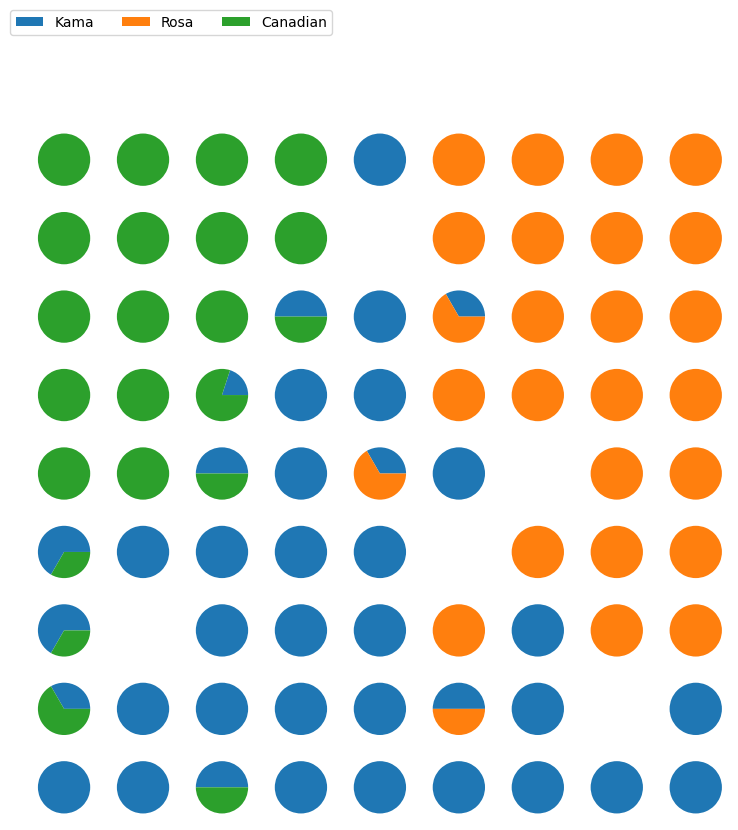

In [49]:
import matplotlib.gridspec as gridspec

labels_map = som.labels_map(data_values, [label_names[t] for t in target])

fig = plt.figure(figsize=(9, 9))
the_grid = gridspec.GridSpec(n_neurons, m_neurons, fig)
for position in labels_map.keys():
    label_fracs = [labels_map[position][l] for l in label_names.values()]
    plt.subplot(the_grid[n_neurons-1-position[1],
                         position[0]], aspect=1)
    patches, texts = plt.pie(label_fracs)

plt.legend(patches, label_names.values(), bbox_to_anchor=(3.5, 6.5), ncol=3)
plt.show()